# Tutorial 2: D to P Exciation in Helium with Atomic Doppler Profile Avergaing, Gaussian Beam Averaging, and Rotation

This tutorial demonstrates how to set up a system and time evolve the sysem averaging over the Gaussian beam profile and the doppler profile of the atoms. We also uses the Wigner-D matrices to rotate the system to a different reference frame and show that this model is physically consistent in all reference frames. 

Start by importing the libraries we will be using.

In [1]:
import LASED as las
import numpy as np

import plotly.graph_objects as go

## Setting up the system

To set up a Laser-Atom system you must first declare the atomic states which you want to work with and label them. We are going to set up an example system for a D-state to a P-state transistion for helium where the P-state is a high principle quantum number Rydberg state. Therefore, we will assume that the wavelength of this fictitious transition is the ionisation energy of helium as this is a very high lying Rydberg state. This system is only for example purposes only and does not exist. 

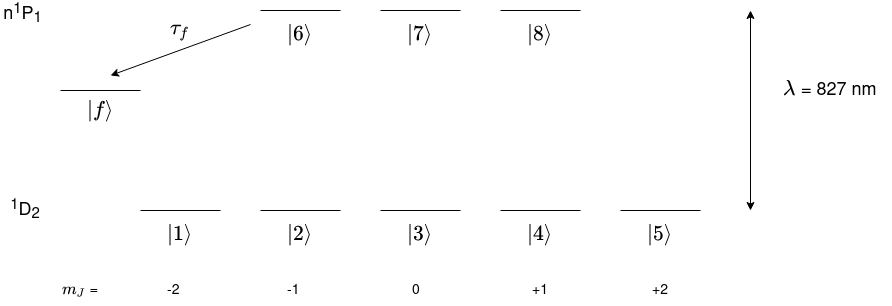

In [2]:
from IPython.display import Image
Image(filename = "LevelDiagrams/HeRydbergDtoP.png")

A level diagram of the system we will model is shown above. 

The `LaserAtomSystem` is setup in the code block below. As the excited state is high-lying its non-radiative lifetime will be comparable to its radiative lifetime. This non-radiative decay to other states outside the system is characterised by the arrow from the upper states to state $|f\rangle$. This can be input into the `LaserAtomSystem` using the keyword `tau_f`.

We will excite this system with simultaneous right-hand circular and left-hand circular polarised light in the natural frame with the laser beam travelling down the quantisation axis. This will be linearly-polarised light in the collision frame where the transverse E-field of the laser is oscillating along the quantisation axis. Therefore, we must set `Q = [-1, 1]` and set the `rabi_factors` to `[1, -1]` as noted in Tutorial 1 and scale the Rabi frequency in the system by using `rabi_scaling`. In this case set it to $1/{\sqrt{2}}$.

Then, we create the sub-states and put them into either the ground or excited states.

In [3]:
# System parameters
n = 8  # number of energy levels in system

laser_wavelength = 827e-9 # wavelength of transition
w_e = las.angularFreq(laser_wavelength)

# Create states
one = las.State(label = 1, w = 0, m = -2, L = 2, S = 0)
two = las.State(label = 2, w = 0, m = -1, L = 2, S = 0)
three = las.State(label = 3, w = 0, m = 0, L = 2, S = 0)
four = las.State(label = 4, w = 0, m = 1, L = 2, S = 0)
five = las.State(label = 5, w = 0, m = 2, L = 2, S = 0)

six = las.State(label = 6, w = w_e, m = -1, L = 1, S = 0)
seven = las.State(label = 7, w = w_e, m = 0, L = 1, S = 0)
eight = las.State(label = 8, w = w_e, m = 1, L = 1, S = 0)


G = [one, two, three, four, five] # ground states
E = [six, seven, eight] # excited states
Q = [-1, 1] # laser radiation polarisation
rabi_scaling_he = 1/np.sqrt(2)
rabi_factors_he = [1, -1]
tau = 100e3 # lifetime in ns (estimated)
tau_f = 100e3 # non-radiative lifetime of rydberg upper state to other states in ns (estimated)

### TEM$_{00}$ Gaussian Beam Profile 

A laser beam usually does not have a flat beam profile (known as a "top-hat" distribution) in intensity. As the beam has spatial variation in intensity the atoms being excited experience a non-uniform time evolution. To model the effects of the beam profile the beam can be split up into regions of approximate uniform intensity and each spatial portion of the beam is used to time-evolve a part of the system being illuminated. Then, each part of the system is summed together and normalised which results in the entire system being modelled.

`LASED` supports the modelling of a Gaussian TEM$_{00}$ laser beam profile. The 2D standard deviation of the Gaussian must be declared with keyword `r_sigma` when performing the `timeEvolution()` of the `LaserAtomSystem`. The number of portions which the beam is split into must be chosen as well. This is declared with the keyword `n_intensity` when using `timeEvolution`. If these are left out then a "top-hat" distribution of laser intensity is assumed. Also, to use the Gaussian avergaing over the beam profile, the keyword `laser_power` must be defined in the `LaserAtomSystem`. This is the total power which the laser delivers as opposed to the intensity over a mm$^2$.

Below, the laser parameters are declared for this system. 

**Note**: If using this averaging the model will loop over the time evolution with the number defined in `n_intensity` so the model will be much slower if a larger number is input. The larger number also results in a more accurate representation of the beam profile. Usually, a `n_intensity` of around 50 is enough for most cases.

In [4]:
# Laser parameters
laser_power = 100 # laser intensity in mW
r_sigma = 0.75  # radial distance to 2D standard deviation in mm
n_intensity = 20

### Doppler Detuning from the Atomic Velocity Profile

When using `LASED` the atoms being excited are usually defined as being stationary unless specified. If the atoms are not stationary and have some velocity with respect to the laser beam then the frequency of the laser is detuned from resonance due to the fixed velocity. In experiments an atomic beam is sometimes used to provide the atoms to some interaction region where the laser-excitation takes place. If a velocity component is in (or opposite to) the direction of the laser beam then detuning occurs. The velocity component can be specified using the `atomic_velocity` keyword in the `timeEvolution()`. This is specified in units of m/s in the direction of the laser beam. If the direction is opposite to this then the `atomic_velocity` is negative. 

Detuning can also occur due to the Maxwell-Boltzmann distribution of atomic velocities. This results in a Gaussian detuning profile. This can be modelled by splitting the detuning due to the velocity distribution of atoms into uniform sections and time-evolving the system with these uniform detunings and then summing up the time evolution for each detuning and normalising. The detuning due to this Doppler broadening can be modelled in `LASED` by defining a `doppler_width` in Grad/s in `timeEvolution()` and a list with all the detunings to be used for the averaging process called `doppler_detunings`. The more elements in `doppler_detunings` the more the time evolution of the system is calculated and the more time it will take to model the system.

**Note**: When using _both_ Doppler and Gaussian beam averaging the number of times the system is time evolved will be `n_intensity` multiplied by the number of elements in `doppler_detunings`.

In [5]:
# Doppler detuning parameters
doppler_width = 0.1*2*np.pi # doppler width in Grad/s
delta_upper = 3*doppler_width
delta_lower = -3*doppler_width
doppler_steps = 20
doppler_detunings = np.linspace(delta_lower, delta_upper, doppler_steps)
atomic_velocity = 0  # Velocity component of atoms in direction of laser beam in m/s

Set the simulation time for 1000 ns every 1 ns as follows:

In [6]:
# Simulation parameters
start_time = 0
stop_time = 1000 # in ns
time_steps = 1000
time = np.linspace(start_time, stop_time, time_steps)

Create the `LaserAtomSystem` object. To set the initial conditions of the density matrix at t = 0 ns $\rho(t = 0)$ we can use the `setRho_0(s1, s2, val)` where `s1` and `s2` are `State` objects denoting the element of the density matrix to be set as $\rho_{s1,s2}$ and `val` denotes the value assigned to this element.

For this system we have set the populations of states $|1\rangle$, $|3\rangle$, and $|5\rangle$ as 1/3. So the density matrix elements $\rho_{11}$ = $\rho_{33}$ = $\rho_{55}$ = 1/3. 

In [7]:
helium_system = las.LaserAtomSystem(E, G, tau, Q, laser_wavelength, tau_f = tau_f, 
                                 laser_intensity = laser_power, laser_power = laser_power,
                                   rabi_scaling = rabi_scaling_he, rabi_factors = rabi_factors_he)
helium_system.setRho_0(one, one, 1/3)
helium_system.setRho_0(three, three, 1/3) 
helium_system.setRho_0(five, five, 1/3)

Time evolve the system.

In [8]:
helium_system.timeEvolution(time, 
                            r_sigma = r_sigma,
                            n_beam_averaging = n_intensity,
                            doppler_width = doppler_width,
                            doppler_detunings = doppler_detunings,
                            beam_profile_averaging = True,
                            doppler_averaging = True)

Now, we can plot the populations using `Plotly` (or any other plotting package).

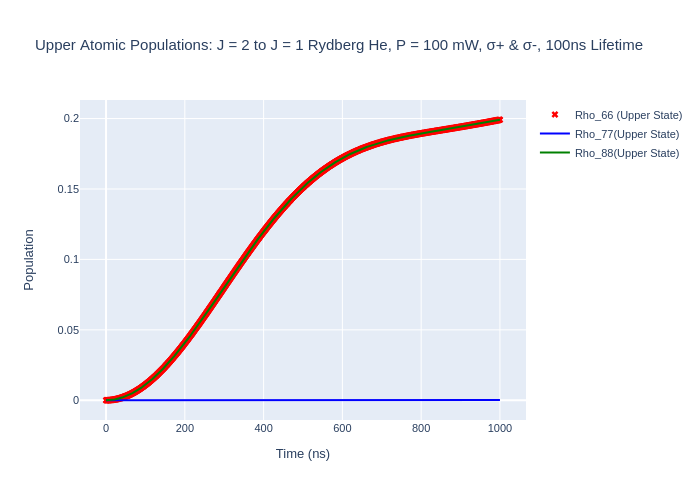

In [9]:
las_sys = helium_system
rho_66 = [ abs(rho) for rho in las_sys.Rho_t(six, six)]
rho_77 = [abs(rho) for rho in las_sys.Rho_t(seven, seven)]
rho_88 = [abs(rho) for rho in las_sys.Rho_t(eight, eight)]

fig_upper = go.Figure(data = go.Scatter(x = time,
                                 y = rho_66,
                                 mode = 'markers',
                                    name = "Rho_66 (Upper State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'x',
                            )))

fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_77,
                                 mode = 'lines',
                                    name = "Rho_77(Upper State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'square',
                           )))
fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_88,
                                 mode = 'lines',
                                    name = "Rho_88(Upper State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                           )))

fig_upper.update_layout(title = "Upper Atomic Populations: J = 2 to J = 1 Rydberg He, P = 100 mW, σ+ & σ-, 100ns Lifetime",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_upper.write_image("SavedPlots/tutorial2-HeFigUpperNatFrame.png")
Image("SavedPlots/tutorial2-HeFigUpperNatFrame.png")

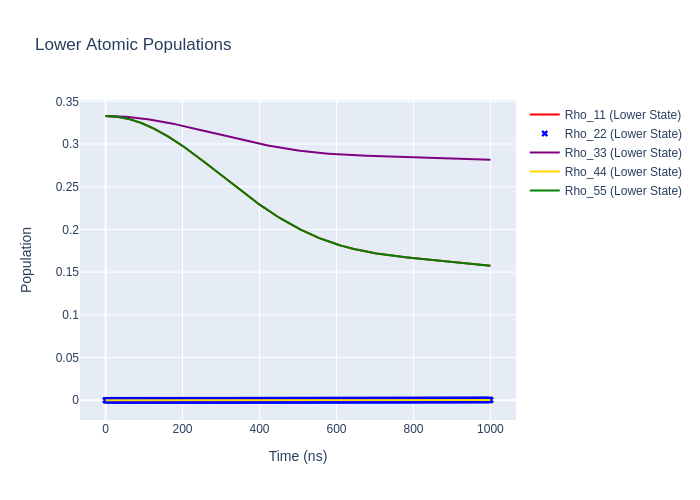

In [10]:
rho11 = [ abs(rho) for rho in las_sys.Rho_t(one, one)]
rho22 = [ abs(rho) for rho in las_sys.Rho_t(two, two)]
rho33 = [ abs(rho) for rho in las_sys.Rho_t(three, three)]
rho44 = [ abs(rho) for rho in las_sys.Rho_t(four, four)]
rho55 = [ abs(rho) for rho in las_sys.Rho_t(five, five)]


fig_lower = go.Figure(data = go.Scatter(x = time,
                                 y = rho11,
                                 mode = 'lines',
                                    name = "Rho_11 (Lower State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho22,
                                 mode = 'markers',
                                    name = "Rho_22 (Lower State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho33,
                                 mode = 'lines',
                                    name = "Rho_33 (Lower State)",
                                    marker = dict(
                                color = 'purple',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho44,
                                 mode = 'lines',
                                    name = "Rho_44 (Lower State)",
                                    marker = dict(
                                color = 'gold',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho55,
                                 mode = 'lines',
                                    name = "Rho_55 (Lower State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'square',
                            )))
fig_lower.update_layout(title = "Lower Atomic Populations",
                        xaxis_title = "Time (ns)",
                 yaxis_title = "Population")

fig_lower.write_image("SavedPlots/tutorial2-HeFigLowerNatFrame.png")
Image("SavedPlots/tutorial2-HeFigLowerNatFrame.png")

## Rotation

With `LASED` we can rotate density matrices to different reference frames using the Wigner-D matrix. 

**Note**: The Wigner-D matrix is only defined for J-represenattion (when isospin I = 0) and therefore when in F-representation the rotation may not be correct. Also, density matrices can only be rotated for single atomic states so the optical coherences between ground and excited states cannot be rotated. To obtain optical coherences in a different reference frame the initial density matrix (at t = 0) must be rotated and time evolved with the polarisation rotated to that frame.
 
The rotation is defined by Euler angles `alpha`, `beta`, and `gamma`. The frame is rotated with each angle in succession so that:
* `alpha` is the rotation (in radians) around the initial z-axis to obtain the new frame Z'
* `beta` is the rotation (in radians) about the new y'-axis to obtain the new frame Z''
* `gamma` is the rotation (in radians) about the new z''-axis to obtain the final frame

In `LASED` to rotate the initial density matrix use `rotateRho_0(alpha, beta, gamma)` on the `LaserAtomSystem`. In this he lium system the atom is changed to be defined in the collision frame from the natural frame so the polarisation is changed to be purely linear with `Q = [0]` and scaled to 1.

**Note**: To simulate a linear polarisation with an angle with respect to the x-axis we can initialise the density matrix in that frame, rotate to the collision frame (with the polarisation aligned with the x-axis, time evolve the system, and then rotate back to the frame where the polarisation is at an angle.

In [11]:
alpha = np.pi/2
beta = np.pi/2
gamma = -np.pi/2
helium_system_rot = helium_system
helium_system_rot.rotateRho_0(alpha, beta, gamma)
helium_system_rot.Q = [0]
helium_system.rabi_scaling = 1
helium_system.rabi_factors = [1]

Now, we can time evolve this system in this new reference frame.

In [12]:
print(helium_system_rot)
helium_system_rot.timeEvolution(time, 
                            r_sigma = r_sigma,
                            n_beam_averaging = n_intensity,
                            doppler_width = doppler_width,
                            doppler_detunings = doppler_detunings,
                            beam_profile_averaging = True,
                            doppler_averaging = True)

LaserAtomSystem([6, 7, 8], [1, 2, 3, 4, 5], 100000.0, [0], [1, 0, -1], 8.27e-07, 100000.0, 100, 100)


Now we can plot what the populations look like.

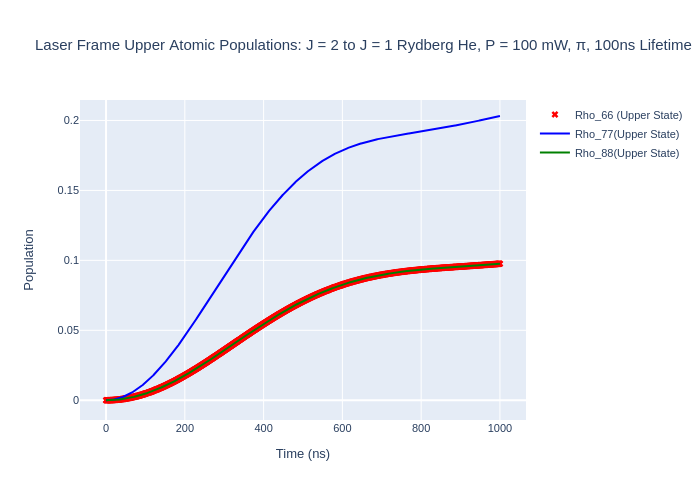

In [13]:
las_sys = helium_system_rot
rho_66 = [ abs(rho) for rho in las_sys.Rho_t(six, six)]
rho_77 = [abs(rho) for rho in las_sys.Rho_t(seven, seven)]
rho_88 = [abs(rho) for rho in las_sys.Rho_t(eight, eight)]

fig_upper = go.Figure(data = go.Scatter(x = time,
                                 y = rho_66,
                                 mode = 'markers',
                                    name = "Rho_66 (Upper State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'x',
                            )))

fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_77,
                                 mode = 'lines',
                                    name = "Rho_77(Upper State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'square',
                           )))
fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_88,
                                 mode = 'lines',
                                    name = "Rho_88(Upper State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                           )))

fig_upper.update_layout(title = "Laser Frame Upper Atomic Populations: J = 2 to J = 1 Rydberg He, P = 100 mW, π, 100ns Lifetime",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_upper.write_image("SavedPlots/tutorial2-HeFigUpperCollFrame.png")
Image("SavedPlots/tutorial2-HeFigUpperCollFrame.png")

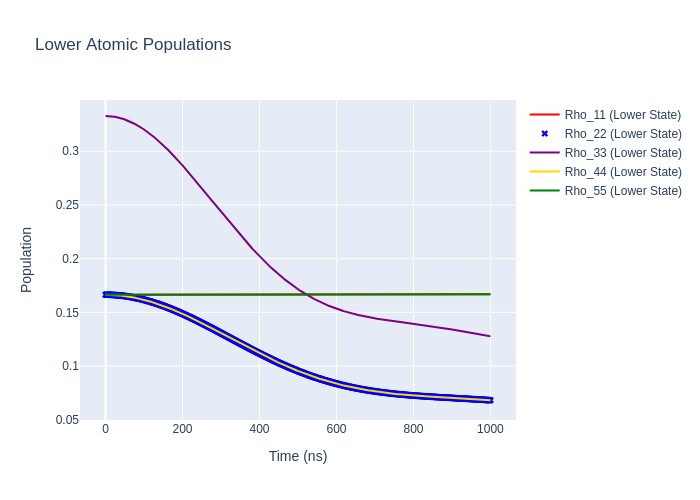

In [14]:
rho11 = [ abs(rho) for rho in las_sys.Rho_t(one, one)]
rho22 = [ abs(rho) for rho in las_sys.Rho_t(two, two)]
rho33 = [ abs(rho) for rho in las_sys.Rho_t(three, three)]
rho44 = [ abs(rho) for rho in las_sys.Rho_t(four, four)]
rho55 = [ abs(rho) for rho in las_sys.Rho_t(five, five)]


fig_lower = go.Figure(data = go.Scatter(x = time,
                                 y = rho11,
                                 mode = 'lines',
                                    name = "Rho_11 (Lower State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho22,
                                 mode = 'markers',
                                    name = "Rho_22 (Lower State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho33,
                                 mode = 'lines',
                                    name = "Rho_33 (Lower State)",
                                    marker = dict(
                                color = 'purple',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho44,
                                 mode = 'lines',
                                    name = "Rho_44 (Lower State)",
                                    marker = dict(
                                color = 'gold',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho55,
                                 mode = 'lines',
                                    name = "Rho_55 (Lower State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'square',
                            )))
fig_lower.update_layout(title = "Lower Atomic Populations",
                        xaxis_title = "Time (ns)",
                 yaxis_title = "Population")

fig_lower.write_image("SavedPlots/tutorial2-HeFigLowerCollFrame.png")
Image("SavedPlots/tutorial2-HeFigLowerCollFrame.png")

If we rotate the time-evolved density matrix `rho_t` back to the natural frame we should get the same populations as when we evolved in the natural frame as the excitation must be the same in all reference frames. We can do this rotation by using `rotateRho_t` on the `LaserAtomSystem`.

**Note**: A message will be thrown saying that the optical coherences are not rotated.

In [15]:
helium_system_rot.rotateRho_t(alpha, -beta, gamma)
print("Natural Frame final populations")

Optical coherences are preserved under rotation. To obtain these in a new reference frame, rotate rho_0 and then evolve in the new reference frame with the correct polarisation.
Natural Frame final populations


Now we can plot the results and obtain the same plots as in the first time evolution.

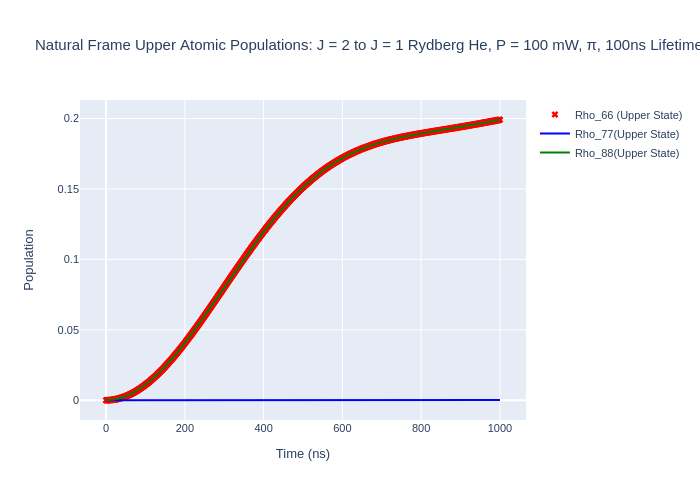

In [16]:
las_sys = helium_system_rot
rho_66 = [ abs(rho) for rho in las_sys.Rho_t(six, six)]
rho_77 = [abs(rho) for rho in las_sys.Rho_t(seven, seven)]
rho_88 = [abs(rho) for rho in las_sys.Rho_t(eight, eight)]

fig_upper = go.Figure(data = go.Scatter(x = time,
                                 y = rho_66,
                                 mode = 'markers',
                                    name = "Rho_66 (Upper State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'x',
                            )))

fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_77,
                                 mode = 'lines',
                                    name = "Rho_77(Upper State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'square',
                           )))
fig_upper.add_trace(go.Scatter(x = time,
                                 y = rho_88,
                                 mode = 'lines',
                                    name = "Rho_88(Upper State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                           )))

fig_upper.update_layout(title = "Natural Frame Upper Atomic Populations: J = 2 to J = 1 Rydberg He, P = 100 mW, π, 100ns Lifetime",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

fig_upper.write_image("SavedPlots/tutorial2-HeFigUpperRotatedToNatFrame.png")
Image("SavedPlots/tutorial2-HeFigUpperRotatedToNatFrame.png")

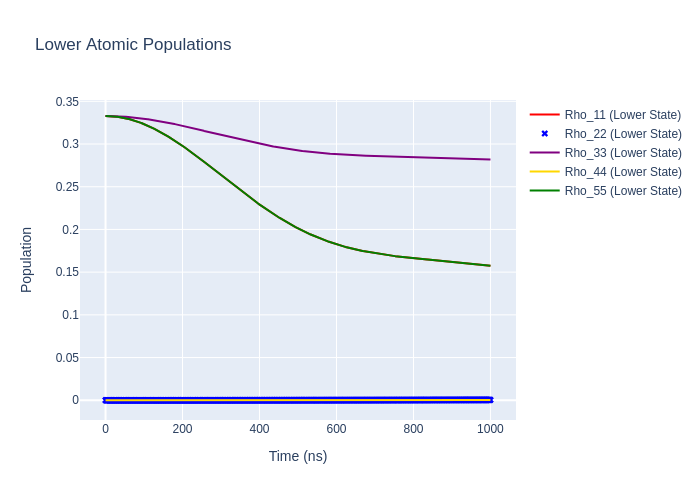

In [17]:
rho11 = [ abs(rho) for rho in las_sys.Rho_t(one, one)]
rho22 = [ abs(rho) for rho in las_sys.Rho_t(two, two)]
rho33 = [ abs(rho) for rho in las_sys.Rho_t(three, three)]
rho44 = [ abs(rho) for rho in las_sys.Rho_t(four, four)]
rho55 = [ abs(rho) for rho in las_sys.Rho_t(five, five)]


fig_lower = go.Figure(data = go.Scatter(x = time,
                                 y = rho11,
                                 mode = 'lines',
                                    name = "Rho_11 (Lower State)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho22,
                                 mode = 'markers',
                                    name = "Rho_22 (Lower State)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho33,
                                 mode = 'lines',
                                    name = "Rho_33 (Lower State)",
                                    marker = dict(
                                color = 'purple',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho44,
                                 mode = 'lines',
                                    name = "Rho_44 (Lower State)",
                                    marker = dict(
                                color = 'gold',
                                symbol = 'x',
                            )))
fig_lower.add_trace(go.Scatter(x = time,
                                 y = rho55,
                                 mode = 'lines',
                                    name = "Rho_55 (Lower State)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'square',
                            )))
fig_lower.update_layout(title = "Lower Atomic Populations",
                        xaxis_title = "Time (ns)",
                 yaxis_title = "Population")

fig_lower.write_image("SavedPlots/tutorial2-HeFigLowerRotatedToNatFrame.png")
Image("SavedPlots/tutorial2-HeFigLowerRotatedToNatFrame.png")